In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import ParameterGrid,TimeSeriesSplit, KFold
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor


from random import gauss
from random import seed

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf,pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm 

import pmdarima as pm
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer

plt.rcParams['figure.figsize'] = (16, 4)

from joblib import Parallel, delayed

from utils import * 


%matplotlib inline 

import itertools



In [2]:
!ls data

data.csv              sample_submission.csv


In [3]:
df = pd.read_csv('data/data.csv')

In [4]:
df.head()

,date,power,exog
0,2020-09-20 00:00:00,976.930,11.805
1,2020-09-20 01:00:00,952.705,11.446
2,2020-09-20 02:00:00,928.813,11.218
3,2020-09-20 03:00:00,984.234,11.025
4,2020-09-20 04:00:00,1002.113,11.196


In [5]:
def plot_data(data, column):
    plt.rcParams['figure.figsize'] = (16, 4)
    data[[column]].plot()
    plt.xlabel('Time')
    plt.title('Power')
    plt.show()

In [6]:
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)

/var/folders/dk/djl_jn195h7gym2_kn27310c0000gn/T/ipykernel_7741/63736465.py:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)


In [7]:
df.date

0       2020-09-20 00:00:00
1       2020-09-20 01:00:00
2       2020-09-20 02:00:00
3       2020-09-20 03:00:00
4       2020-09-20 04:00:00
                ...        
26899   2023-10-15 19:00:00
26900   2023-10-15 20:00:00
26901   2023-10-15 21:00:00
26902   2023-10-15 22:00:00
26903   2023-10-15 23:00:00
Name: date, Length: 26904, dtype: datetime64[ns]

In [8]:
df.isnull().sum()

date       0
power    219
exog     259
dtype: int64

In [9]:
df.tail()

,date,power,exog
26899,2023-10-15 19:00:00,NaN,10.820
26900,2023-10-15 20:00:00,NaN,10.619
26901,2023-10-15 21:00:00,NaN,9.535
26902,2023-10-15 22:00:00,NaN,10.031
26903,2023-10-15 23:00:00,NaN,9.464


In [10]:
df = df.set_index('date').sort_index()

In [11]:
df

,power,exog
date,,
2020-09-20 00:00:00,976.930,11.805
2020-09-20 01:00:00,952.705,11.446
2020-09-20 02:00:00,928.813,11.218
2020-09-20 03:00:00,984.234,11.025
2020-09-20 04:00:00,1002.113,11.196
...,...,...
2023-10-15 19:00:00,NaN,10.820
2023-10-15 20:00:00,NaN,10.619
2023-10-15 21:00:00,NaN,9.535


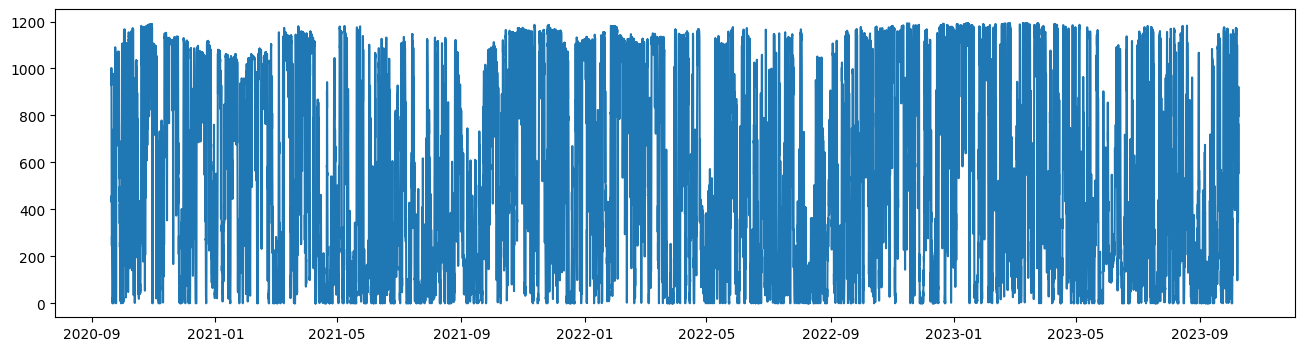

In [12]:
plt.plot(df.power)

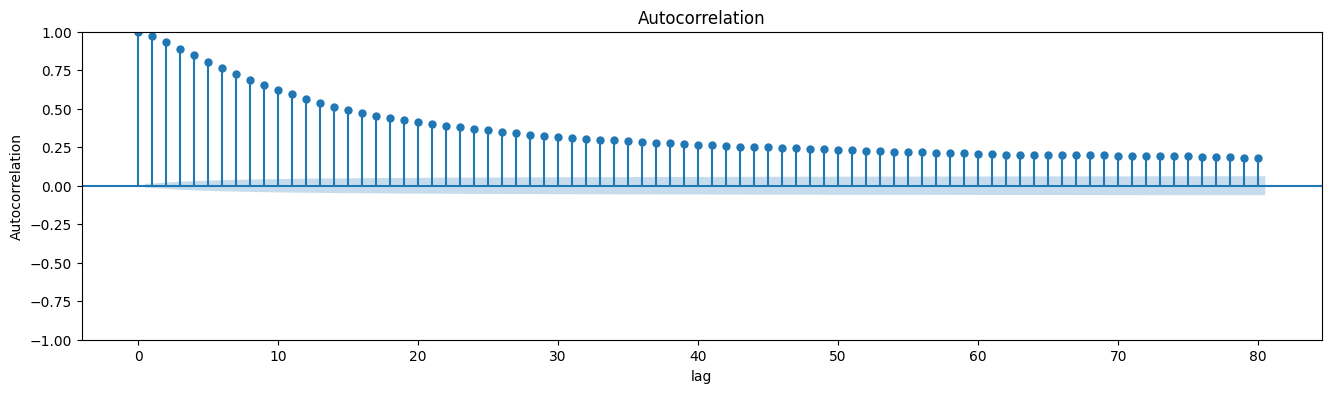

In [13]:
plot_acf(df.drop(["exog"], axis=1).dropna(), alpha=.05, lags=80)
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

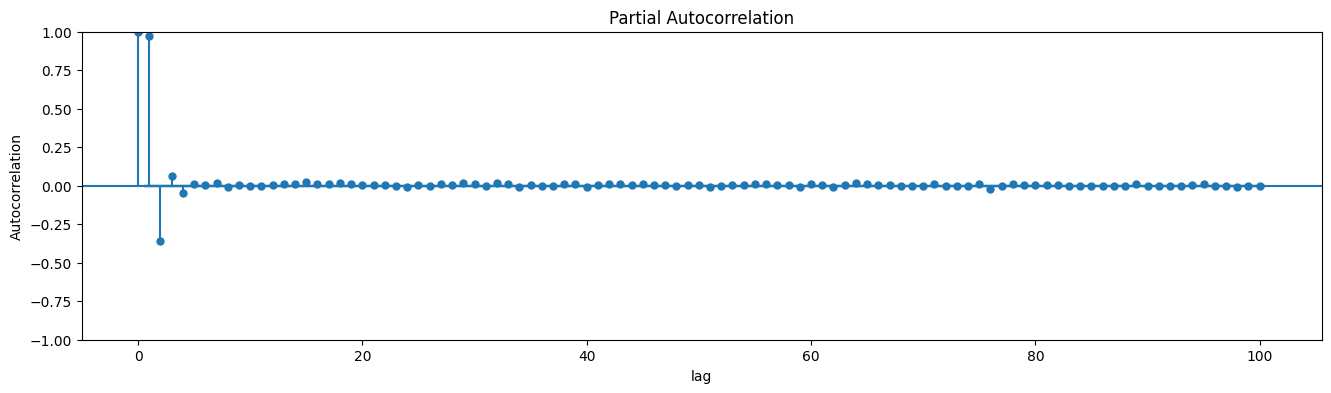

In [53]:
plot_pacf(df.drop(["exog"], axis=1).dropna(), alpha=0.05, lags=100, method='ols')
plt.xlabel('lag')
plt.ylabel('Autocorrelation')
plt.show()

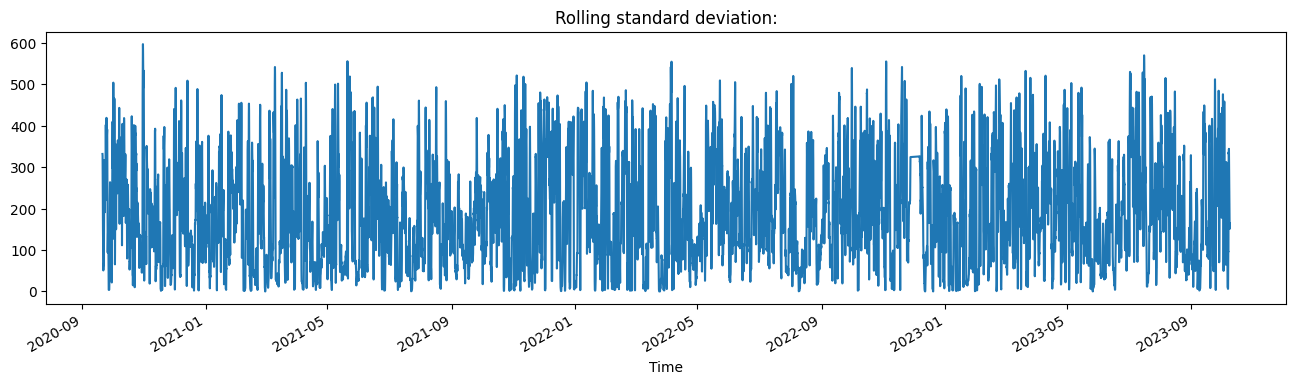

In [15]:
(df.dropna().power).rolling(24).std().plot();
plt.xlabel('Time')
plt.title('Rolling standard deviation:')
plt.show()

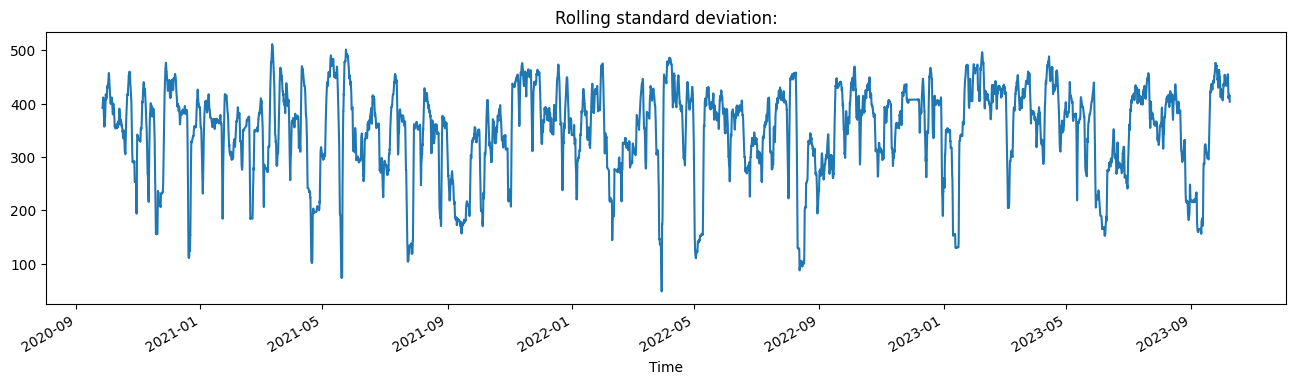

In [54]:
(df.dropna().power).rolling(24*7).std().plot();
plt.xlabel('Time')
plt.title('Rolling standard deviation:')
plt.show()

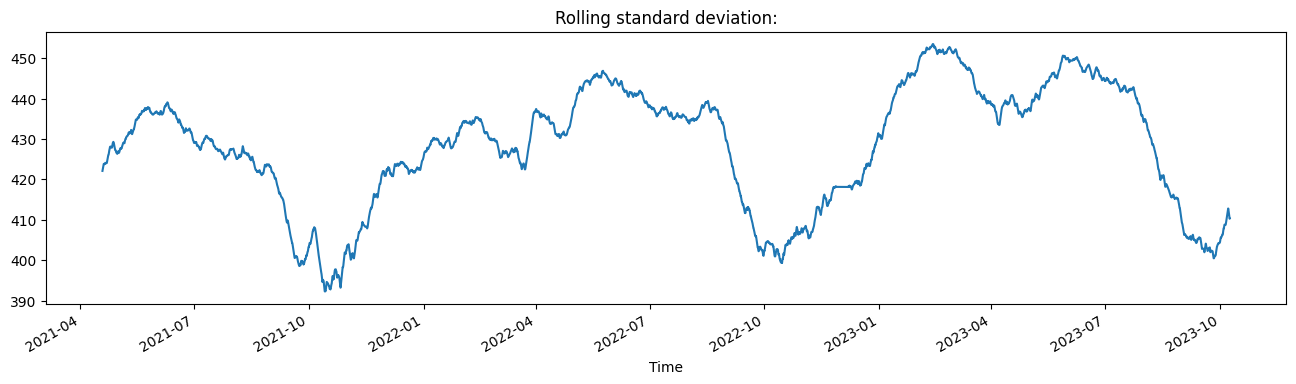

In [55]:
(df.dropna().power).rolling(24*7*30).std().plot();
plt.xlabel('Time')
plt.title('Rolling standard deviation:')
plt.show()

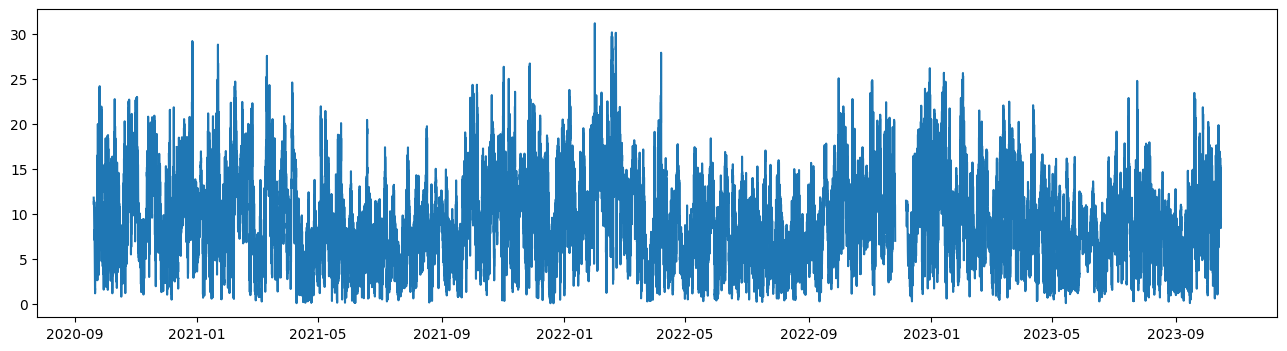

In [16]:
plt.plot(df.exog)

In [17]:
data_v2 = df.resample('H').asfreq()
data_v2.isnull().sum()

power    219
exog     259
dtype: int64

SLICE TRAINING DATA -TES DATA

In [ ]:
#df_imputed

In [ ]:
df

In [18]:
df.loc[df.isnull().power]

,power,exog
date,,
2021-11-15 00:00:00,NaN,10.797
2021-11-15 01:00:00,NaN,5.656
2023-06-03 23:00:00,NaN,7.302
2023-06-04 00:00:00,NaN,7.449
2023-06-04 01:00:00,NaN,5.281
...,...,...
2023-10-15 19:00:00,NaN,10.820
2023-10-15 20:00:00,NaN,10.619
2023-10-15 21:00:00,NaN,9.535


In [19]:
beginning_date = '2020-09-20 00:00:00'#'2015-01-01'
#val_split_date = '2021-01-01 00:00:00'
test_split_date = '2021-11-15 00:00:00'
data = df.drop(["exog"], axis=1)
train = df.loc[(beginning_date <= df.index) & (df.index < test_split_date)]
#val = df.loc[(val_split_date <= df.index) & (df.index < test_split_date)]
test = df.loc[df.index >= test_split_date]

Imputing exog

In [22]:
test.loc[df.isnull().exog]

,power,exog
date,,
2022-11-26 01:00:00,580.336,NaN
2022-11-26 02:00:00,596.496,NaN
2022-11-26 04:00:00,404.866,NaN
2022-11-26 05:00:00,425.436,NaN
2022-11-26 07:00:00,422.475,NaN
...,...,...
2022-12-06 13:00:00,601.413,NaN
2022-12-06 14:00:00,708.723,NaN
2022-12-06 15:00:00,918.781,NaN


In [23]:
interval = slice('2020-10-16','2022-12-06')

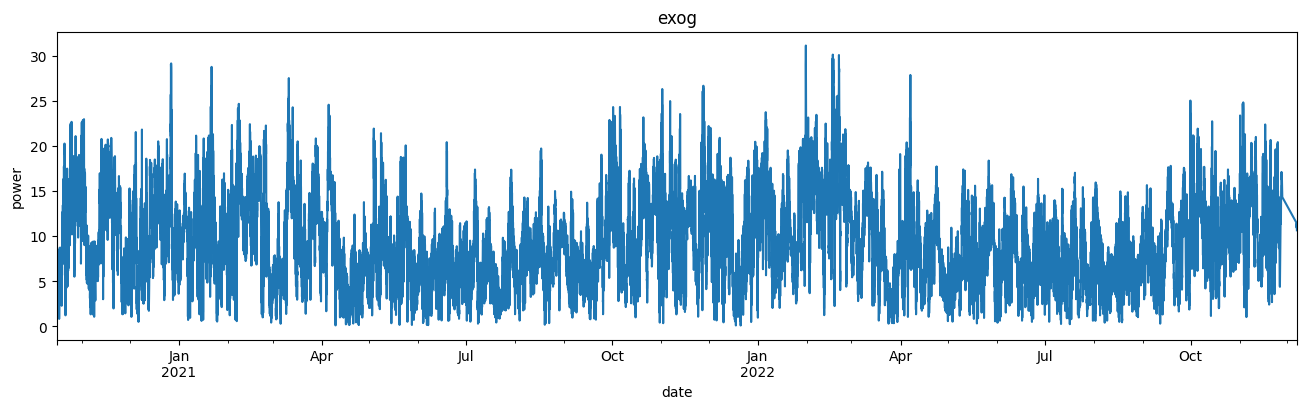

In [24]:
df.loc[interval].exog.interpolate().plot()
plt.ylabel('power')
plt.title('exog')
plt.show()

In [25]:
from sklearn.impute import KNNImputer
imputer = KNNImputer() # To obtain better results we may want to have more neighbors, of course that in a real setting
                       # this is a parameter that should be tunned
    
data_imputed = imputer.fit_transform(df)

In [26]:
data_imputed 

array([[976.93  ,  11.805 ],
       [952.705 ,  11.446 ],
       [928.813 ,  11.218 ],
       ...,
       [431.4904,   9.535 ],
       [326.3808,  10.031 ],
       [539.3082,   9.464 ]])

In [27]:
df_imputed =pd.DataFrame(data_imputed, index=df.index, columns=df.columns)

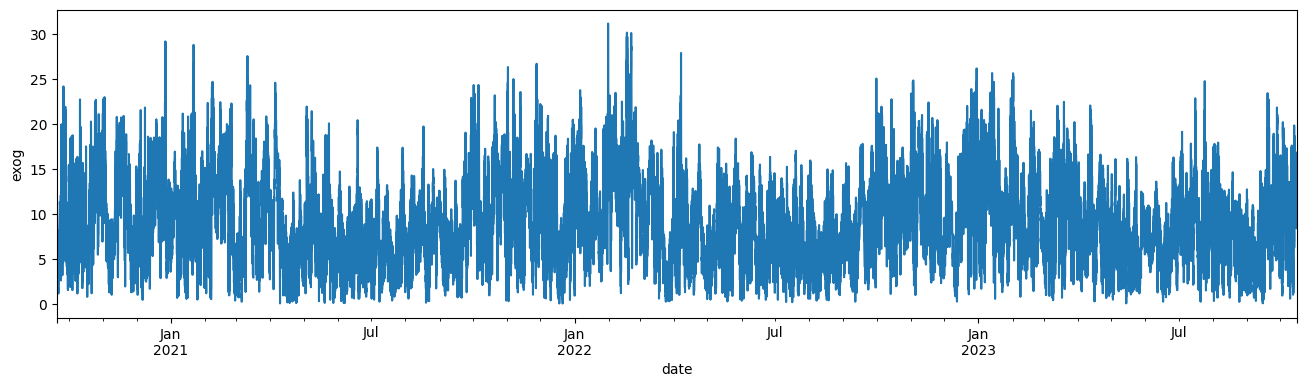

In [28]:
df_imputed.exog.plot()
plt.ylabel('exog')
plt.show()

In [29]:
df_imputed.loc[df.isnull().exog]

,power,exog
date,,
2020-10-16 07:00:00,784.684,10.0784
2020-10-16 08:00:00,769.902,17.5112
2020-12-11 07:00:00,1069.043,11.2930
2020-12-11 08:00:00,1030.524,10.5994
2020-12-11 10:00:00,1002.268,12.3206
...,...,...
2022-12-06 13:00:00,601.413,9.3510
2022-12-06 14:00:00,708.723,9.0202
2022-12-06 15:00:00,918.781,12.2032


Build features

In [35]:
X = df_imputed.copy()

In [36]:
df_feat = build_some_features(X,df['power'])

KeyError: "None of [Index([  976.93,  952.705,  928.813,  984.234, 1002.113,  996.167,  970.203,\n        890.502,    711.4,  543.451,\n       ...\n            nan,      nan,      nan,      nan,      nan,      nan,      nan,\n            nan,      nan,      nan],\n      dtype='float64', length=26904)] are in the [columns]"

In [37]:
from sklearn.model_selection import ParameterGrid
param_grid = {'model': [LinearRegression(), GradientBoostingRegressor()], 
              'num_periods_lagged':[0, 1, 2, 24],
              'num_periods_diffed':[0],
              "lags": [[]],
              'hour': [True],
              'weekday':[True],
              'month':[True],
              'holidays': [True],
              'rolling' : [[],[np.mean,np.min,np.max,np.std]]
             }

grid = ParameterGrid(param_grid)

In [41]:
def date_to_datetime(data):
    data.time = pd.to_datetime(data.time, infer_datetime_format=True)

    data = data.set_index('time', drop=True)  

    return data  

def slice_dates(data, beginning_date, end_date):
    return data[(data.index>=beginning_date)&(data.index<=end_date)]


In [43]:
data

,date,power,exog
0,2020-09-20 00:00:00,976.930,11.805
1,2020-09-20 01:00:00,952.705,11.446
2,2020-09-20 02:00:00,928.813,11.218
3,2020-09-20 03:00:00,984.234,11.025
4,2020-09-20 04:00:00,1002.113,11.196
...,...,...,...
26899,2023-10-15 19:00:00,NaN,10.820
26900,2023-10-15 20:00:00,NaN,10.619
26901,2023-10-15 21:00:00,NaN,9.535
26902,2023-10-15 22:00:00,NaN,10.031


In [46]:
data = pd.read_csv('data/data.csv')
data['date'] = pd.to_datetime(data['date'], infer_datetime_format=True)
data = data.set_index('date').sort_index()


/var/folders/dk/djl_jn195h7gym2_kn27310c0000gn/T/ipykernel_7741/33893949.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data['date'] = pd.to_datetime(data['date'], infer_datetime_format=True)


In [48]:
data


,power,exog
date,,
2020-09-20 00:00:00,976.930,11.805
2020-09-20 01:00:00,952.705,11.446
2020-09-20 02:00:00,928.813,11.218
2020-09-20 03:00:00,984.234,11.025
2020-09-20 04:00:00,1002.113,11.196
...,...,...
2023-10-15 19:00:00,NaN,10.820
2023-10-15 20:00:00,NaN,10.619
2023-10-15 21:00:00,NaN,9.535


In [47]:
data.loc[df.isnull().power]

,power,exog
date,,
2021-11-15 00:00:00,NaN,10.797
2021-11-15 01:00:00,NaN,5.656
2023-06-03 23:00:00,NaN,7.302
2023-06-04 00:00:00,NaN,7.449
2023-06-04 01:00:00,NaN,5.281
...,...,...
2023-10-15 19:00:00,NaN,10.820
2023-10-15 20:00:00,NaN,10.619
2023-10-15 21:00:00,NaN,9.535


In [45]:
from sklearn.model_selection import ParameterGrid
param_grid = {'model': [LinearRegression(), GradientBoostingRegressor()], 
              'num_periods_lagged':[0, 1, 2, 24],
              'num_periods_diffed':[0],
              "lags": [[]],
              'hour': [True],
              'weekday':[True],
              'month':[True],
              'holidays': [True],
              'rolling' : [[],[np.mean,np.min,np.max,np.std]]
             }

grid = ParameterGrid(param_grid)

In [ ]:
beginning_date = '2020-09-20 00:00:00'#'2015-01-01'
val_split_date = '2017-12-11'
test_split_date = '2021-11-15 00:00:00'
data = data.drop(["exog"], axis=1)
train = data.loc[(beginning_date <= data.index) & (data.index < val_split_date)]
val = data.loc[(val_split_date <= data.index) & (data.index < test_split_date)]
test = data.loc[data.index >= test_split_date]